In [1]:
import utils
from utils import *
import xgboost as xgb


# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import itertools

import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import *

# from brew.base import Ensemble, EnsembleClassifier
# from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
# from brew.combination.combiner import Combiner


%matplotlib inline


/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))


In [3]:
train_features = load_array("data/cache/abhishek_qfreq_nostrov_lstm_neighbourcount_3gram_maxcore_train.dat")
test_features = load_array("data/cache/abhishek_qfreq_nostrov_lstm_neighbourcount_3gram_maxcore_test.dat")

train_features.shape, test_features.shape

((404290, 72), (2345796, 72))

In [4]:
from sklearn.preprocessing import StandardScaler



In [5]:


train_features = np.nan_to_num(train_features)
test_features = np.nan_to_num(test_features)

### Models

In [13]:
clf1 = AdaBoostClassifier()
clf2 = RandomForestClassifier(n_jobs=-1,verbose=1)
clf3 = ExtraTreesClassifier(n_jobs=-1,verbose=1)

In [24]:
# sclf.(test_features[:2,0:5])

In [61]:
from sklearn.ensemble import *

clfs = [RandomForestClassifier(n_estimators=500, n_jobs=-1, criterion='gini',verbose=1) ]
#         ,
#         RandomForestClassifier(n_estimators=500, n_jobs=-1, criterion='entropy'),
#         ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='gini'),
#         ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='entropy')]

In [62]:
dataset_blend_train = np.zeros((train_features.shape[0], len(clfs)+1))
dataset_blend_test = np.zeros((test_features.shape[0], len(clfs)+1))


In [6]:
num_folds = 5
X = train_features
X_submission = test_features
y = labels


In [7]:
X = np.clip(X,X.min(),1e7)
X_submission = np.clip(X_submission,X_submission.min(),1e7)
# X_submission = np.nan_to_num(StandardScaler().fit_transform(X_submission))

In [8]:
skf = StratifiedKFold(n_splits=num_folds, random_state=2019)
skf  = list(skf.split(X, labels))

#### Kfold

In [12]:

for j, clf in enumerate(clfs):
    print j, clf
    dataset_blend_test_j = np.zeros((test_features.shape[0], num_folds))


    for i, (train, test) in enumerate(skf):
        print "Fold", i
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        clf.fit(X_train, y_train)
        
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_submission)[:, 1]
        
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

#### Caliberated CV

In [9]:
np.random.seed(2189)

perm = np.random.permutation(len(train_features))
ix_fit = perm[:int(len(train_features)*(1-0.1))]
ix_valid = perm[int(len(train_features)*(1-0.1)):]

X_train = X[ix_fit]
X_valid = X[ix_valid]


y_val = labels[ix_valid]
y_train = labels[ix_fit]


In [9]:
# X_train = np.nan_to_num(StandardScaler().fit_transform(X_train))
# X_valid = np.nan_to_num(StandardScaler().fit_transform(X_valid))



In [10]:
from sklearn.calibration import CalibratedClassifierCV


In [68]:
for j, clf in enumerate(clfs):
    print j, clf
    
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
    calibrated_clf.fit(X_train, y_train)
    valid_preds  = calibrated_clf.predict_proba(X_valid)
    print "%.2f" % log_loss(y_val, valid_preds)

0 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 500 out of 500 

0.24


logloss results: 

    isotonic:
        clipping > 0.23
        withtout clipping  > 0.23

    sigmoid: 0.24

In [11]:
# with open("weights/caliberated_RF.bk","w") as f:
#     pickle.dump(calibrated_clf,f,pickle.HIGHEST_PROTOCOL)

with open("weights/caliberated_RF.bk","r") as f:
    calibrated_clf = pickle.load(f)

In [13]:
clf_valid_preds = calibrated_clf.predict_proba(X_valid)

In [20]:
chunk_sizek_size = len(X_submission)/4
clf_preds = np.zeros((X_submission.shape[0],1))


In [79]:
for i in range(4):
    clf_preds[(i*chunk_size):((i+1)*chunk_size)] = calibrated_clf.predict_proba(X_submission[i*chunk_size:(i+1)*chunk_size])[:,1].reshape(-1,1)

In [31]:
clf_preds.max()

0.99992386285489732

In [39]:
# save_array("data/results/RF_isotonic_test_preds.dat",clf_preds)

In [13]:
# print "Blending."
# clf = LogisticRegression()
# clf.fit(dataset_blend_train, y)
# y_submission = clf.predict_proba(dataset_blend_test)[:, 1]

In [14]:
def read_cache():
    
    global scores2
    global models2
    global params2
    
    with open("data/cache/xgb_models_randomized.pik", 'r') as f:
        models2 = pickle.load(f)	    

    with open("data/cache/xgb_scores_randomized.pik", 'r') as f:
        scores2 = pickle.load(f)	    

    with open("data/cache/xgb_params_randomized.pik", 'r') as f:
        params2 = pickle.load(f)	    
    


In [15]:
read_cache()

In [16]:
preds = np.zeros((X_valid.shape[0],1))
count = 0 

d_valid = xgb.DMatrix(X_valid,label=y_val)

for m in tqdm_notebook(models2):
    if m.best_score <= np.median(scores2):
        p_valid = m.predict(d_valid)
        preds += p_valid.reshape(-1,1)
        count +=1

In [65]:
xgb_preds_valid_avg = preds / float(count) #devide by number of folds  

In [69]:
submission_weights=[]
submission_weights.append( 1-log_loss(y_val,xgb_preds_valid_avg))
submission_weights.append( 1-log_loss(y_val,clf_valid_preds))
submission_weights

[0.86939545822889752, 0.76964582227853962]

In [19]:
from sklearn.linear_model import LogisticRegression

In [42]:
lr = LogisticRegression()
lr.fit (np.hstack((link_function(preds_valid_avg.reshape(-1,1)),link_function(clf_valid_preds[:,1].reshape(-1,1)))),y_val)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

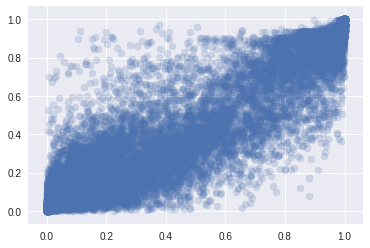

In [44]:
plt.scatter(link_function(preds_valid_avg.reshape(-1,1)),link_function(clf_valid_preds[:,1].reshape(-1,1)),alpha=0.2)

In [36]:
lr.predict_proba(np.hstack((preds_valid_avg.reshape(-1,1),clf_valid_preds[:,1].reshape(-1,1))))

array([[ 0.00958189,  0.99041811],
       [ 0.99461824,  0.00538176],
       [ 0.99855056,  0.00144944],
       ..., 
       [ 0.9967767 ,  0.0032233 ],
       [ 0.76801398,  0.23198602],
       [ 0.00623121,  0.99376879]])

In [45]:
lr.coef_

array([[ 29.33009866, -15.42019852]])

##### test_preds

In [70]:
clf_preds = load_array("data/results/RF_isotonic_test_preds.dat")
xgb_preds = pd.read_csv("subm/xgb_randomized_bestof15.csv")

In [71]:
t = xgb_preds.is_duplicate.values 

In [59]:
clf_preds.shape

(2345796, 1)

1.639041280507437

In [74]:
mean_preds= submission_weights[0]*t.reshape(-1,1)+ submission_weights[1]*link_function(clf_preds.reshape(-1,1))
mean_preds /= np.sum(submission_weights)

In [76]:
mean_preds[0:5].reshape(-1,1)

array([[  8.96372461e-05],
       [  6.71922517e-02],
       [  1.42795910e-01],
       [  6.68758740e-03],
       [  2.79300803e-03]])

In [56]:
mean_preds[0:5]

array([[  8.66611376e-05],
       [  6.56326810e-02],
       [  1.41329689e-01],
       [  7.09418371e-03],
       [  2.94638970e-03]])

In [73]:
t.reshape(-1,1)[0:5]

array([[  1.35563218e-04],
       [  9.12588473e-02],
       [  1.65421975e-01],
       [  4.13175481e-04],
       [  4.26090872e-04]])

In [ ]:
clf.estimator_params

In [59]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': mean_preds.ravel()})
sub.head(2)

,is_duplicate,test_id
0,0.000087,0
1,0.065633,1


In [60]:
submission_name = "subm/xgb_randomized_plust_rf_caliberated.csv"

sub.to_csv(path+submission_name, index=False)
FileLink(submission_name)

/home/ubuntu/quora/subm/xgb_randomized_plust_rf_caliberated.csv